In [6]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
# from keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import Nadam
import math
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
import random
import numpy
from tensorflow.compat.v1.random import set_random_seed

random.seed(1)
numpy.random.seed(1)
set_random_seed(2)

In [8]:
def mse(predictions, targets):
        return ((predictions - targets) ** 2).mean()

In [9]:
def readDataset(filename):
    text_file = open(filename, 'r')
    dataset = []   
    for line in text_file:  
        line = line.split(',')      
        dt = [ float(x) for x in line ]
        dataset.append(dt)    
    text_file.close()
    dataset = np.array(dataset)
    return dataset

In [10]:
def tagData(data, perc):
    sz = math.ceil(data.shape[0]*perc/100)
    dat = np.zeros((data.shape[0], data.shape[1]*2))
    dat[:data.shape[0], :data.shape[1]] =data  #append column for labels
    dat[:data.shape[0]-1, data.shape[1]:] =data[1:,:]  #append column for labels   
    
    xtrain = dat[:sz, :4]
    ytrain = dat[:sz, 4:]
    
    xtest = dat[sz-1:, :4]
    ytest = dat[sz-1:, 4:]
    
    xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
    xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
    
    return xtrain, ytrain, xtest, ytest

In [11]:
percentage = 60

In [12]:
file = '../Data/EURUSDmicro_ H4_CandleData.txt'
data = readDataset(file)
xtrain, ytrain,xtest,ytest = tagData(data,percentage)

print('training samples: ', xtrain.shape)
print('testing samples: ', xtest.shape)

training samples:  (6047, 1, 4)
testing samples:  (4031, 1, 4)


In [13]:
class Models_FLF():
    def __init__(self, activations):
        self.activations = activations
        self.history_dictionary = {}
        self.opt = Nadam(lr=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=None, schedule_decay=0.0004)
        self.predictions = {}
        
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    def mse(self, predictions, targets):
        return ((predictions - targets) ** 2).mean()
    
    @tf.function
    def FLF(self, yTrue, yPred):
        lam = 0.1
        v   = Lambda(lambda x: x*0.9)((yTrue-yPred))
        vn  = Lambda(lambda x: x*lam)(K.abs((yTrue[:,1]+yTrue[:,2])/2 - (yPred[:,1]+yPred[:,2])/2))
        vn1 = Lambda(lambda x: x*lam)(K.abs((yTrue[:,0]+yTrue[:,3])/2 - (yPred[:,0]+yPred[:,3])/2))
        vx  = K.square((v[:,0]-vn1))
        vy  = K.square((v[:,1]-vn))
        vz  = K.square((v[:,2]-vn))
        v4  = K.square((v[:,3]-vn1))
        vm  = K.concatenate([vx, vy, vz, v4])
        vmx = K.mean(vm)
        return vmx
    
    def train_all(self, xtrain, ytrain, units=100, epochs = 20, verbose=2):
        
        for i, act in enumerate(self.activations):
            start =  time.time()
            cand = Sequential()
            ## CuDNNLSTM() from tf.keras.layers.
            cand.add(LSTM(units, input_shape=(xtrain.shape[1], xtrain.shape[2]) ,  activation=act))  ## CuDNNLSTM() from tf.keras.layers.
            cand.add(Dense(4))
            ############################
            cand.compile(loss=self.FLF, optimizer=self.opt)#'Nadam'
            cand_history = cand.fit(xtrain, ytrain, epochs=epochs, batch_size=72, validation_data=(xtest, ytest), verbose=verbose, shuffle=False)
            self.history_dictionary[act] = (cand_history, cand)
            print("done training model with activation", act, "  ", i+1,"/", len(self.activations), "completed.")
            end =  time.time()
            print("time of execution = ", end-start, "seconds")
    
    def plot_validation_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history = pair[0]
            plt.plot(cand_history.history['val_loss'], label=label)
            plt.title('Candle validation loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
    
    def plot_train_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history =pair[0]
            plt.plot(cand_history.history['loss'], label= label)
            plt.title('Candle training loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
        
    def evaluate(self, xtest, name="Open"):
        print('predicting candles and evaluating models...')
        mapp = {"Open": 0, "High":1, "Low":2, "Close":3}
        groups = {"Open": [], "High":[], "Low": [], "Close": []}
        for label, pair in self.history_dictionary.items():
            model =pair[1]
            prediCand = model.predict(xtest)
            self.predictions[label] = prediCand
            for name, id_ in mapp.items():
                pred = prediCand[:,id_]
                act = ytest[:,id_]
                mean_sq_err = self.mse(act, pred)
                print(label, ": ", name, " MSE => ", mean_sq_err)
                groups[name].append(mean_sq_err)
            print(".................................................")
        return groups
    
    def plot(self, name="Open"):
        mapp = {"Open": 0, "open":0,  "High":1, "high":1 ,   "Low":2, "low":2 , "Close":3, "close":3 }
        plt.figure(figsize=(8,5))
        id_ = mapp[name]
        act = ytest[:,id_]
        label_2 = 'actual '+ name + ' price'
        plt.plot(act[:len(act)-1],     label = label_2)
        for label, prediCand in self.predictions.items():
            pred = prediCand[:, id_]
            label_1 = label+ ': Predicted '+ name + ' price'
            plt.plot(pred[:len(pred)-1],   label = label_1);
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title('EUR/USD '+ name +' price')
            plt.grid(True)
            plt.legend(loc = 'best')
        plt.show()
        
    def plot_error(self, dictionary, n):
        # set width of bar
        barWidth = 0.12
        # Set position of bar on X axis
        r1 = np.arange(n)
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        plt.figure(figsize=(5, 4))
        # Make the plot
        if(n==2):
            dictionary2={}
            groups = ['tanh', 'relu']
            for k, v in dictionary.items():
                dictionary2[k] = [v[0], v[2]]
        elif(n==3):
            groups = ['tanh', 'sigmoid', 'relu']
            dictionary2 = dictionary

        plt.bar(r1, dictionary2['Open'],  color='#7f6d5f', width=barWidth, edgecolor='white', label='Open-Price')
        plt.bar(r2, dictionary2['High'],  color='#fc9803', width=barWidth, edgecolor='white', label='High-Price')
        plt.bar(r3, dictionary2['Low'],   color='#2d7f5e', width=barWidth, edgecolor='white', label='Low-Price')
        plt.bar(r4, dictionary2['Close'], color='#2003fc', width=barWidth, edgecolor='white', label='Close-Price')

        # Add xticks on the middle of the group bars
        plt.xlabel('activation function', fontweight='bold')
        plt.ylabel('Mean Square Error', fontweight='bold')
        plt.xticks([r + barWidth for r in range(n)], groups)
        # Create legend & Show graphic
        plt.legend(loc= "best")
        plt.show()
    def save_pred(self, path= ""):
        for k, v in self.predictions.items():
            file_name = path + "/FLF_" + k + ".csv"
            df = pd.DataFrame()
            df['Open'] = v[:,0]
            df['High'] = v[:,1]
            df['Low'] =  v[:,2]
            df['Close'] = v[:,3]
            df.to_csv(file_name)
        print("done writting all..")
        

In [14]:
activations=['tanh', 'sigmoid', 'relu']

m = Models_FLF(activations)

In [15]:
m.train_all(xtrain, ytrain, units = 250, epochs = 150, verbose=0)

done training model with activation tanh    1 / 3 completed.
time of execution =  158.965265750885 seconds
done training model with activation sigmoid    2 / 3 completed.
time of execution =  148.5693998336792 seconds
done training model with activation relu    3 / 3 completed.
time of execution =  145.36164116859436 seconds


In [16]:
dictionary  = m.evaluate(xtest)

predicting candles and evaluating models...
tanh :  Open  MSE =>  0.0003784927557516858
tanh :  High  MSE =>  0.0003673879486716088
tanh :  Low  MSE =>  0.0003851443743430264
tanh :  Close  MSE =>  0.00037275086221909764
.................................................
sigmoid :  Open  MSE =>  0.018992297915502217
sigmoid :  High  MSE =>  0.01894037392261376
sigmoid :  Low  MSE =>  0.01616300586191342
sigmoid :  Close  MSE =>  0.02438679659481711
.................................................
relu :  Open  MSE =>  0.0003568259543816606
relu :  High  MSE =>  0.0004138557129315487
relu :  Low  MSE =>  0.00036485547443876646
relu :  Close  MSE =>  0.00037602697421432413
.................................................


In [17]:
path = '../Data'
m.save_pred(path)

done writting all..


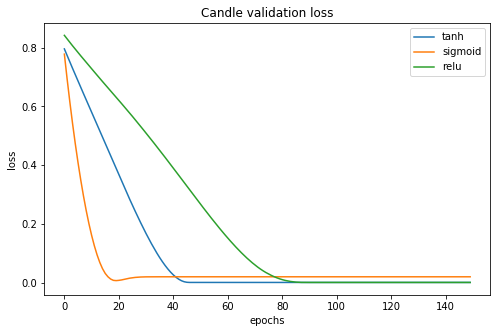

In [18]:
m.plot_validation_loss()

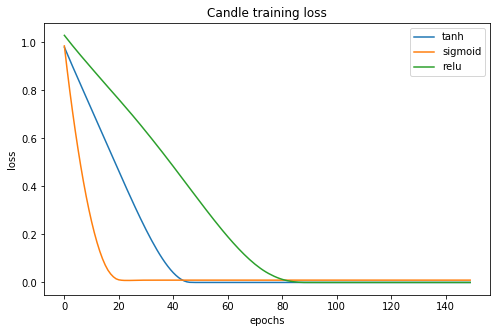

In [19]:
m.plot_train_loss()

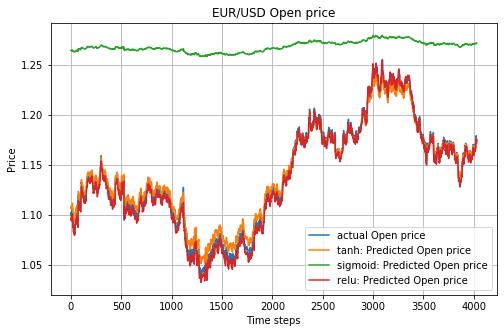

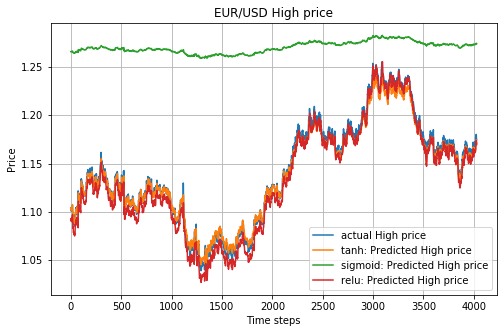

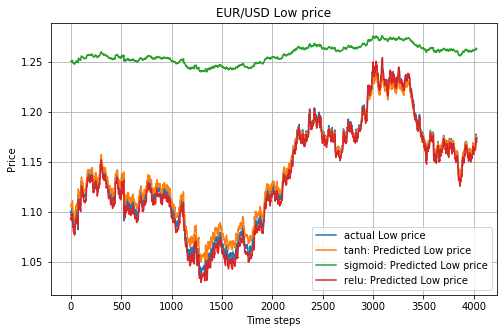

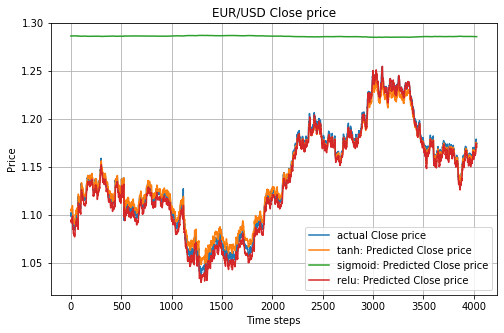

In [20]:
m.plot(name="Open")
m.plot(name="High")
m.plot(name="Low")
m.plot(name="Close")

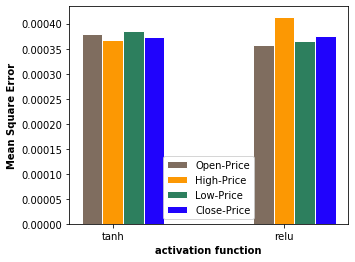

In [21]:
m.plot_error(dictionary, n=2)

In [22]:
# modelFolder = '../Models/'
# cand.save(modelFolder+'FLF_lamda=0.0001.h5')